<a href="https://colab.research.google.com/github/ymkproject/Causal-Reinforcement-Learning-for-Bandits-with-Confounders/blob/main/Causal_Reinforcement_Learning_for_Bandits_with_Confounders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 40.0 MB/s eta 0:00:00
[Binary] 실행 1/20 (Source P(Z=1)=0.9, Target P(Z=1)=0.5, alpha_source=0.35, alpha_target=0.15)
[Binary] 실행 2/20 (Source P(Z=1)=0.9, Target P(Z=1)=0.5, alpha_source=0.35, alpha_target=0.15)
[Binary] 실행 3/20 (Source P(Z=1)=0.9, Target P(Z=1)=0.5, alpha_source=0.35, alpha_target=0.15)
[Binary] 실행 4/20 (Source P(Z=1)=0.9, Target P(Z=1)=0.5, alpha_source=0.35, alpha_target=0.15)
[Binary] 실행 5/20 (Source P(Z=1)=0.9, Target P(Z=1)=0.5, alpha_source=0.35, alpha_target=0.15)
[Binary] 실행 6/20 (Source P(Z=1)=0.9, Target P(Z=1)=0.5, alpha_source=0.35, alpha_target=0.15)
[Binary] 실행 7/20 (Source P(Z=1)=0.9, Target P(Z=1)=0.5, alpha_source=0.35, alpha_target=0.15)
[Binary] 실행 8/20 (Source P(Z=1)=0.9, Target P(Z=1)=0.5, alpha_source=0.35, alpha_target=0.15)
[Binary] 실행 9/20 (Source P(Z=1)=0.9, Target P(Z=1)=0.5, alpha_source=0.35, alpha_target=0.15)
[Binary] 실행 10/20 (Source P(Z=1)=0.9, Target P(Z=1)=0.5, alpha_source=0.35, a

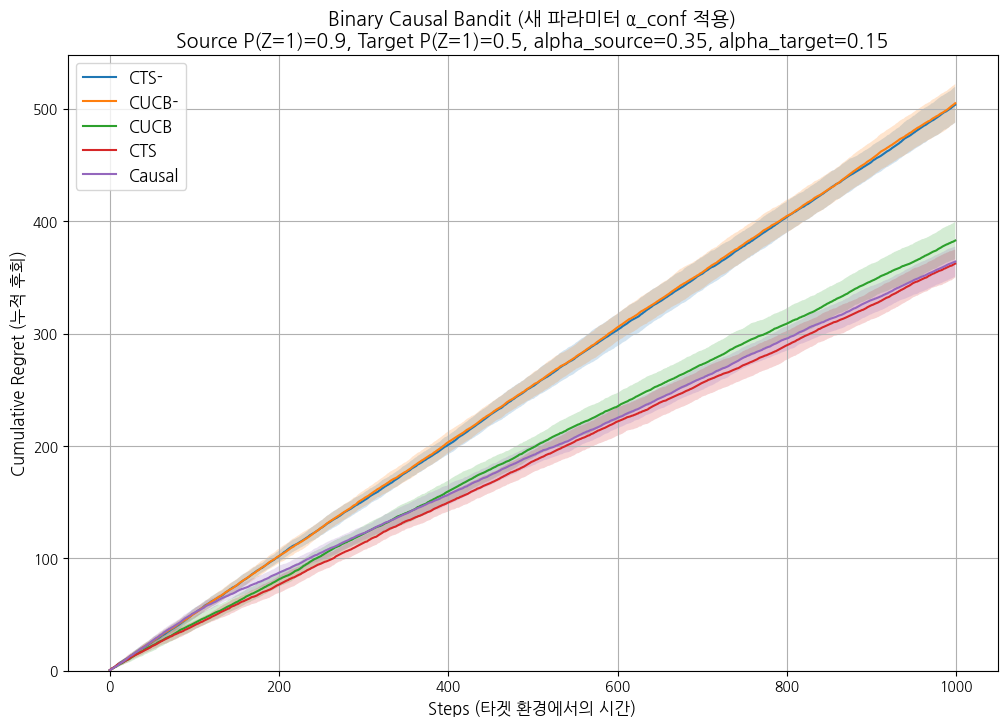


--- [알고리즘 2] 사전 훈련 단계 시작 ---
디코더 훈련 중...
디코더 훈련 완료.
Causal VAE(인코더) 훈련 중...
Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 28.7204 - reconstruction_loss: 1090.8519 - total_loss: 1093.7241
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 162.3869 - reconstruction_loss: 715.1391 - total_loss: 731.3779
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 337.3451 - reconstruction_loss: 719.0682 - total_loss: 752.8026
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 342.9223 - reconstruction_loss: 713.9542 - total_loss: 748.2466
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 325.8852 - reconstruction_loss: 721.6537 - total_loss: 754.2422
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 348.9207 - reconstruction_loss: 706.4689 - total_loss: 741.3609
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 342.3586 - reconstruction_loss: 708.2812 - total_loss: 742.5172
Epoch 8/50
157/157 ━━━━━━━━━━━━━━

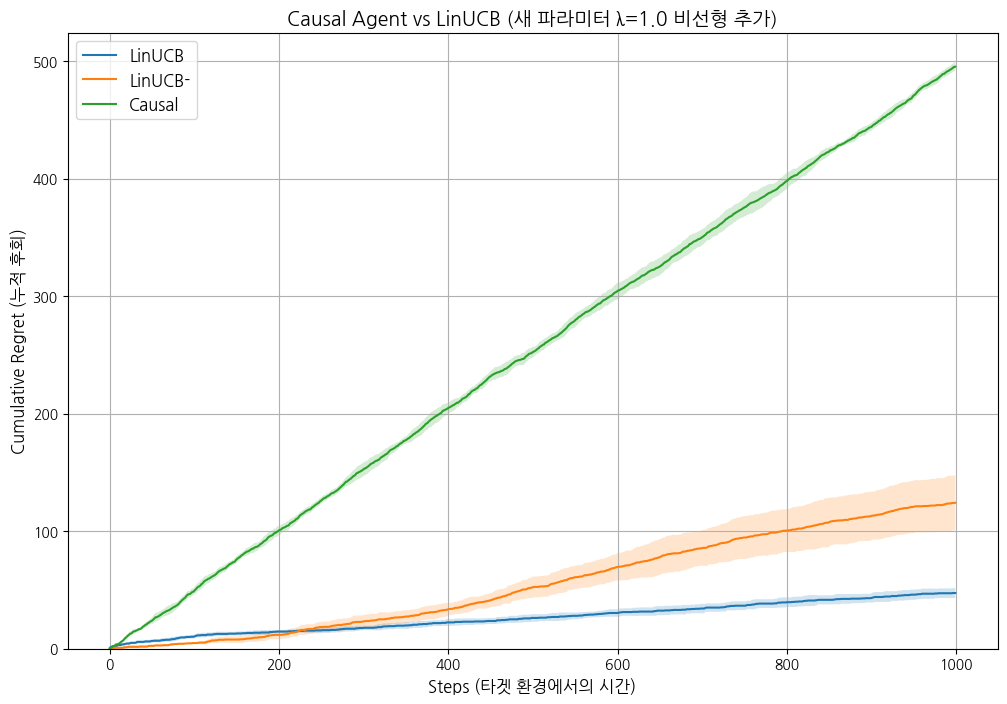

In [1]:
# -*- coding: utf-8 -*-
# 비관측 교란 요인을 가진 밴딧 문제를 위한 인과 강화학습
# 알고리즘 1: Binary Causal Bandit
# 알고리즘 2: Continuous (VAE) Causal Bandit
#
# ✅ 논문에서 쓰지 않은 "새로운 파라미터"들
# 1) Binary 환경용: alpha_conf (교란 강도)
#    P(X'=1 | Z=1) = 0.5 + alpha_conf
#    P(X'=1 | Z=0) = 0.5 - alpha_conf
#    → 원 논문은 0.1 / 0.8로 고정. 우리는 source / target에서 alpha를 따로 줌.
#
# 2) Continuous 환경용: NONLINEAR_STRENGTH (비선형 항 강도)
#    W = linear(Z) + NONLINEAR_STRENGTH * sin(Z) + noise
#    → 원 논문은 순수 선형; 우리는 구조적 비선형 교란을 추가.

# ============================================================
# 1. Binary Causal Bandit (알고리즘 1)
# ============================================================

!pip install koreanize-matplotlib

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import warnings
import platform
from matplotlib import font_manager, rc

import koreanize_matplotlib

warnings.filterwarnings('ignore', category=RuntimeWarning)
plt.rcParams['axes.unicode_minus'] = False


# ------------------------------------------------------------
# 1-1. 시뮬레이션 환경 (새 파라미터: alpha_conf)
# ------------------------------------------------------------

class CausalBanditEnvironment:
    """
    비관측 교란 Z, 관측 컨텍스트 X', 행동 A∈{0,1}, 보상 Y∈{0,1} 환경.

    새 파라미터: alpha_conf (0 < alpha_conf < 0.5)
      P(X'=1 | Z=1) = 0.5 + alpha_conf
      P(X'=1 | Z=0) = 0.5 - alpha_conf
    alpha_conf가 클수록 X'가 Z를 더 잘 드러내므로 '교란 강도'가 커졌다고 볼 수 있음.
    """

    def __init__(self, prob_z_is_1, alpha_conf=0.35):
        self.prob_z_is_1 = prob_z_is_1
        self.alpha_conf = alpha_conf

    def sample_z(self):
        """Z ~ Bernoulli(P(Z=1))"""
        return np.random.choice([0, 1], p=[1 - self.prob_z_is_1, self.prob_z_is_1])

    def prob_x1_given_z(self, z):
        """P(X'=1 | Z=z)를 alpha_conf로 일반화"""
        if z == 1:
            p = 0.5 + self.alpha_conf
        else:
            p = 0.5 - self.alpha_conf
        return float(np.clip(p, 0.01, 0.99))

    def sample_x_prime_given_z(self, z):
        """Z가 주어졌을 때 X'를 샘플링"""
        p = self.prob_x1_given_z(z)
        x_prime = np.random.choice([0, 1], p=[1 - p, p])
        return x_prime, p

    def get_context_and_optimal_action(self):
        """
        반환:
        - x_prime: 관측 컨텍스트
        - optimal_action: Z에 의해 결정되는 최적 행동 (1-Z)
        - z: 비관측 교란 (분석용)
        """
        z = self.sample_z()
        x_prime, _ = self.sample_x_prime_given_z(z)
        optimal_action = 1 - z
        return x_prime, optimal_action, z

    def get_reward(self, chosen_action, optimal_action):
        return 1 if chosen_action == optimal_action else 0


# ------------------------------------------------------------
# 1-2. 에이전트들 (CUCB, CTS, Causal)
# ------------------------------------------------------------

class CUCBAgent:
    """CUCB와 CUCB-(Trained) 역할을 모두 수행하는 에이전트"""

    def __init__(self, c=2.0):
        self.c = c
        self.q_table = np.zeros((2, 2))              # (x', a)
        self.n_table = np.ones((2, 2)) * 1e-5        # 방문 횟수

    def choose_action(self, x_prime, t):
        ucb_values = np.zeros(2)
        for action in [0, 1]:
            avg_r = self.q_table[x_prime, action] / self.n_table[x_prime, action]
            bonus = np.sqrt(self.c * np.log(t + 1) / self.n_table[x_prime, action])
            ucb_values[action] = avg_r + bonus
        return np.argmax(ucb_values)

    def update(self, x_prime, action, reward):
        self.q_table[x_prime, action] += reward
        self.n_table[x_prime, action] += 1


class CTSAgent:
    """CTS와 CTS-(Trained) 역할을 모두 수행하는 에이전트"""

    def __init__(self):
        # Beta(α, β) 파라미터 for P(Y=1 | X', A)
        self.beta_params = np.ones((2, 2, 2))  # (x', a, [alpha, beta])

    def choose_action(self, x_prime):
        samples = np.zeros(2)
        for action in [0, 1]:
            alpha, beta_val = self.beta_params[x_prime, action]
            samples[action] = beta.rvs(alpha, beta_val)
        return np.argmax(samples)

    def update(self, x_prime, action, reward):
        if reward == 1:
            self.beta_params[x_prime, action, 0] += 1
        else:
            self.beta_params[x_prime, action, 1] += 1


class CausalAgent:
    """
    논문식 Causal Bandit 에이전트.
    - p_x_prime_given_z: P(X'=1 | Z=z)
    - p_y_given_x_z[a,z]: P(Y=1 | A=a, Z=z)
    """

    def __init__(self):
        self.p_x_prime_given_z = np.zeros(2)      # z=0,1
        self.p_y_given_x_z = np.zeros((2, 2))     # (a,z)
        self.history_x_prime = []

    def choose_action(self, x_prime):
        self.history_x_prime.append(x_prime)

        # 초기에는 랜덤
        if len(self.history_x_prime) < 100:
            return np.random.choice([0, 1])

        # (1) 타겟 도메인에서 P*(X'=1) 추정
        p_star_x1 = np.mean(self.history_x_prime)

        # (2) 소스에서 얻어둔 P(X'=1|Z)
        p_x1_z0, p_x1_z1 = self.p_x_prime_given_z
        denom = p_x1_z1 - p_x1_z0
        if np.isclose(denom, 0):
            return np.random.choice([0, 1])

        # (3) P*(Z=1) 역추정
        p_star_z1 = np.clip((p_star_x1 - p_x1_z0) / denom, 0, 1)
        p_star_z0 = 1 - p_star_z1

        # (4) P*(Z | X') 계산
        if x_prime == 1:
            num_z1 = p_x1_z1 * p_star_z1
            num_z0 = p_x1_z0 * p_star_z0
        else:
            num_z1 = (1 - p_x1_z1) * p_star_z1
            num_z0 = (1 - p_x1_z0) * p_star_z0

        post_denom = num_z0 + num_z1
        if np.isclose(post_denom, 0):
            return np.random.choice([0, 1])

        p_z1_x = num_z1 / post_denom
        p_z0_x = 1 - p_z1_x

        # (5) 각 행동별 기대 보상 u(x') 계산
        u_x = np.zeros(2)
        for a in [0, 1]:
            u_x[a] = (self.p_y_given_x_z[a, 0] * p_z0_x +
                      self.p_y_given_x_z[a, 1] * p_z1_x)
        return np.argmax(u_x)

    def update(self, x_prime, action, reward):
        # 온라인 업데이트는 하지 않고, 소스에서 추정된 파라미터만 사용
        pass


# ------------------------------------------------------------
# 1-3. 훈련 및 시뮬레이션 (alpha_conf까지 포함)
# ------------------------------------------------------------

def train_source(agent, env, steps):
    """소스 환경에서 CTS / CUCB를 미리 훈련"""
    for _ in range(steps):
        x_prime, opt_action, _ = env.get_context_and_optimal_action()
        action = np.random.choice([0, 1])  # 탐색 위해 랜덤
        reward = env.get_reward(action, opt_action)
        if isinstance(agent, CausalAgent):
            pass
        else:
            agent.update(x_prime, action, reward)
    return agent


def run_simulation(agents, source_prob, target_prob,
                   alpha_source, alpha_target,
                   train_steps, eval_steps, num_runs):
    """
    새 파라미터: alpha_source, alpha_target
    - source_env: P(X'|Z)에서 alpha_source 사용
    - target_env: alpha_target 사용 (논문과 다르게, confounding 구조도 도메인마다 다름)
    """
    source_env = CausalBanditEnvironment(prob_z_is_1=source_prob,
                                         alpha_conf=alpha_source)
    target_env = CausalBanditEnvironment(prob_z_is_1=target_prob,
                                         alpha_conf=alpha_target)

    all_regrets = {name: [] for name in agents.keys()}

    for run in range(num_runs):
        print(f"[Binary] 실행 {run + 1}/{num_runs} "
              f"(Source P(Z=1)={source_prob}, Target P(Z=1)={target_prob}, "
              f"alpha_source={alpha_source:.2f}, alpha_target={alpha_target:.2f})")

        # --- 소스 환경에서 CTS-, CUCB- 사전 훈련 ---
        trained_cucb = train_source(CUCBAgent(), source_env, train_steps)
        trained_cts = train_source(CTSAgent(), source_env, train_steps)

        # --- CausalAgent용 소스 도메인 추정 ---
        causal_agent = CausalAgent()
        n_x1_z = np.zeros(2)
        n_z = np.zeros(2)
        q_table_source = np.zeros((2, 2))          # (a,z)
        n_table_source = np.ones((2, 2)) * 1e-5

        for _ in range(train_steps):
            x_prime, opt_a, z = source_env.get_context_and_optimal_action()
            n_z[z] += 1
            if x_prime == 1:
                n_x1_z[z] += 1

            a = np.random.choice([0, 1])
            r = source_env.get_reward(a, opt_a)
            q_table_source[a, z] += r
            n_table_source[a, z] += 1

        causal_agent.p_x_prime_given_z[0] = n_x1_z[0] / n_z[0]
        causal_agent.p_x_prime_given_z[1] = n_x1_z[1] / n_z[1]
        causal_agent.p_y_given_x_z = q_table_source / n_table_source

        # --- 평가용 에이전트 인스턴스 ---
        agent_instances = {
            'CTS-': trained_cts,
            'CUCB-': trained_cucb,
            'CUCB': CUCBAgent(),
            'CTS': CTSAgent(),
            'Causal': causal_agent
        }

        # --- 타겟 환경에서 평가 ---
        for name, agent in agent_instances.items():
            cumulative_regret = 0
            regret_history = []

            for t in range(eval_steps):
                x_prime, opt_action, _ = target_env.get_context_and_optimal_action()

                if isinstance(agent, CUCBAgent):
                    action = agent.choose_action(x_prime, t)
                else:
                    action = agent.choose_action(x_prime)

                reward = target_env.get_reward(action, opt_action)

                # CTS-, CUCB-, 순수 CTS/CUCB는 온라인 업데이트 허용
                if name in ['CTS-', 'CUCB-', 'CUCB', 'CTS']:
                    agent.update(x_prime, action, reward)

                regret = 1 - reward
                cumulative_regret += regret
                regret_history.append(cumulative_regret)

            all_regrets[name].append(regret_history)

    return all_regrets


# ============================================================
# 2. Continuous + VAE Causal Bandit (알고리즘 2)
# ============================================================

import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K
import matplotlib.pyplot as plt
import copy


# ------------------------------------------------------------
# 2-1. 환경 & 데이터 (새 파라미터: NONLINEAR_STRENGTH)
# ------------------------------------------------------------

Z_DIM = 1
W_DIM = 5

SOURCE_Z_MEAN, SOURCE_Z_STD = 20.0, 1.0
TARGET_Z_MEAN, TARGET_Z_STD = 0.0, 5.0

# 선형 부분
TRUE_W_MATRIX = np.random.randn(Z_DIM, W_DIM) * 2
TRUE_W_BIAS = np.random.randn(W_DIM) * 3

# 🔥 새 파라미터: 비선형 항 강도
NONLINEAR_STRENGTH = 1.0   # 0이면 기존 논문과 동일 (순수 선형), >0이면 sin(Z) 비선형 추가


def generate_data(num_samples, z_mean, z_std, nonlinear_strength=NONLINEAR_STRENGTH):
    """
    Z ~ N(z_mean, z_std)
    W = WZ + bias + nonlinear_strength * sin(Z) + noise
    """
    z = np.random.normal(loc=z_mean, scale=z_std, size=(num_samples, Z_DIM))
    linear_part = z.dot(TRUE_W_MATRIX) + TRUE_W_BIAS
    nonlinear_part = nonlinear_strength * np.sin(z)   # 새 파라미터로 조절
    w_mean = linear_part + nonlinear_part
    w = w_mean + np.random.normal(scale=0.5, size=(num_samples, W_DIM))
    return z, w


class ContinuousCausalBanditEnv:
    """
    연속형 Z, W 환경.
    NONLINEAR_STRENGTH로 Z→W 관계의 비선형 정도를 조절.
    """

    def __init__(self, is_target_domain=False, nonlinear_strength=NONLINEAR_STRENGTH):
        self.z_mean = TARGET_Z_MEAN if is_target_domain else SOURCE_Z_MEAN
        self.z_std = TARGET_Z_STD if is_target_domain else SOURCE_Z_STD
        self.nonlinear_strength = nonlinear_strength

    def get_context_and_optimal_action(self):
        z = np.random.normal(loc=self.z_mean, scale=self.z_std, size=(1, Z_DIM))
        linear_part = z.dot(TRUE_W_MATRIX) + TRUE_W_BIAS
        nonlinear_part = self.nonlinear_strength * np.sin(z)
        w = linear_part + nonlinear_part + np.random.normal(scale=0.5, size=(1, W_DIM))
        optimal_action = 0 if z[0, 0] >= 0 else 1
        return w, optimal_action

    def get_reward(self, chosen_action, optimal_action):
        return 1 if chosen_action == optimal_action else 0


# ------------------------------------------------------------
# 2-2. 에이전트들 (LinUCB, VAE 기반 Causal)
# ------------------------------------------------------------

class LinUCBAgent:
    def __init__(self, n_arms=2, n_dims=W_DIM, alpha=1.0):
        self.n_arms = n_arms
        self.n_dims = n_dims
        self.alpha = alpha
        self.A = [np.identity(n_dims) for _ in range(n_arms)]
        self.b = [np.zeros(n_dims) for _ in range(n_arms)]

    def choose_action(self, context):
        context = context.reshape(-1)
        p_t = np.zeros(self.n_arms)
        for arm in range(self.n_arms):
            A_inv = np.linalg.inv(self.A[arm])
            theta = A_inv.dot(self.b[arm])
            p_t[arm] = theta.T.dot(context) + self.alpha * np.sqrt(
                context.T.dot(A_inv).dot(context)
            )
        return np.argmax(p_t)

    def update(self, context, action, reward):
        context = context.reshape(-1)
        self.A[action] += np.outer(context, context)
        self.b[action] += reward * context


class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(Model):
    def __init__(self, encoder, decoder, beta_weight, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder, self.decoder, self.beta_weight = encoder, decoder, beta_weight
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    @tf.function
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(data - reconstruction), axis=1)
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + self.beta_weight * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}


class CausalVAEAgent:
    def __init__(self, pre_trained_encoder):
        self.encoder = pre_trained_encoder

    def choose_action(self, context_w):
        z_mean, _, _ = self.encoder.predict(context_w, verbose=0)
        inferred_z = z_mean[0][0]
        return 0 if inferred_z >= 0 else 1

    def update(self, context, action, reward):
        pass  # 오프라인 학습된 인코더만 사용


# ------------------------------------------------------------
# 2-3. 시뮬레이션
# ------------------------------------------------------------

def run_online_simulation(agent, env, steps):
    cumulative_regret = 0
    regret_history = []
    for t in range(steps):
        w_current, opt_action = env.get_context_and_optimal_action()
        chosen_action = agent.choose_action(w_current)
        reward = env.get_reward(chosen_action, opt_action)
        if isinstance(agent, LinUCBAgent):
            agent.update(w_current, chosen_action, reward)
        regret = 1 - reward
        cumulative_regret += regret
        regret_history.append(cumulative_regret)
    return regret_history


# ============================================================
# 3. 메인 실행부
# ============================================================

if __name__ == "__main__":

    # --------------------------------------------------------
    # [알고리즘 1] Binary Causal Bandit
    # --------------------------------------------------------
    TRAIN_STEPS_1 = 5000
    EVAL_STEPS_1 = 1000
    NUM_RUNS_1 = 20

    SOURCE_PROB = 0.9
    TARGET_PROB = 0.5

    # 🔥 새 파라미터: 교란 강도 (source / target 다르게)
    ALPHA_SOURCE = 0.35   # 논문 기본값과 비슷 (P(X'=1|Z=0)=0.15, Z=1=0.85 근처)
    ALPHA_TARGET = 0.15   # 타겟에서는 교란이 약한 상황으로 설정

    agents_to_run_1 = {
        "CTS-": CTSAgent,
        "CUCB-": CUCBAgent,
        "CUCB": CUCBAgent,
        "CTS": CTSAgent,
        "Causal": CausalAgent,
    }

    results_1 = run_simulation(
        agents_to_run_1,
        SOURCE_PROB,
        TARGET_PROB,
        ALPHA_SOURCE,
        ALPHA_TARGET,
        TRAIN_STEPS_1,
        EVAL_STEPS_1,
        NUM_RUNS_1,
    )

    plt.figure(figsize=(12, 8))
    agent_order = ["CTS-", "CUCB-", "CUCB", "CTS", "Causal"]
    for name in agent_order:
        regrets = results_1[name]
        mean_regret = np.mean(regrets, axis=0)
        std_regret = np.std(regrets, axis=0)
        plt.plot(mean_regret, label=name)
        plt.fill_between(
            range(EVAL_STEPS_1),
            mean_regret - std_regret,
            mean_regret + std_regret,
            alpha=0.2,
        )

    plt.title(
        f"Binary Causal Bandit (새 파라미터 α_conf 적용)\n"
        f"Source P(Z=1)={SOURCE_PROB}, Target P(Z=1)={TARGET_PROB}, "
        f"alpha_source={ALPHA_SOURCE}, alpha_target={ALPHA_TARGET}",
        fontsize=14,
    )
    plt.xlabel("Steps (타겟 환경에서의 시간)", fontsize=12)
    plt.ylabel("Cumulative Regret (누적 후회)", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.ylim(0)
    plt.show()

    # --------------------------------------------------------
    # [알고리즘 2] Continuous + VAE Causal Bandit
    # --------------------------------------------------------
    print("\n--- [알고리즘 2] 사전 훈련 단계 시작 ---")

    TRAIN_SAMPLES = 5000
    DECODER_EPOCHS = 30
    VAE_EPOCHS = 50
    BETA = 0.1
    EVAL_STEPS_2 = 1000
    NUM_RUNS_2 = 5

    # 1) 디코더 훈련 (소스 도메인 데이터)
    print("디코더 훈련 중...")
    z_source, w_source = generate_data(TRAIN_SAMPLES, SOURCE_Z_MEAN, SOURCE_Z_STD,
                                       nonlinear_strength=NONLINEAR_STRENGTH)
    decoder_input = layers.Input(shape=(Z_DIM,))
    x = layers.Dense(32, activation="relu")(decoder_input)
    x = layers.Dense(32, activation="relu")(x)
    decoder_output = layers.Dense(W_DIM)(x)
    decoder_model = Model(decoder_input, decoder_output, name="decoder")
    decoder_model.compile(optimizer="adam", loss="mse")
    decoder_model.fit(z_source, w_source, epochs=DECODER_EPOCHS, batch_size=32, verbose=0)
    decoder_model.save_weights("decoder_weights.weights.h5")
    print("디코더 훈련 완료.")

    # 2) Causal VAE (인코더) 훈련 (타겟 도메인 데이터)
    print("Causal VAE(인코더) 훈련 중...")
    _, w_target_train = generate_data(TRAIN_SAMPLES, TARGET_Z_MEAN, TARGET_Z_STD,
                                      nonlinear_strength=NONLINEAR_STRENGTH)
    encoder_input = layers.Input(shape=(W_DIM,))
    x = layers.Dense(32, activation="relu")(encoder_input)
    x = layers.Dense(32, activation="relu")(x)
    z_mean = layers.Dense(Z_DIM)(x)
    z_log_var = layers.Dense(Z_DIM)(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

    decoder_for_vae = Model(decoder_input, decoder_output, name="decoder_for_vae")
    decoder_for_vae.load_weights("decoder_weights.weights.h5")
    decoder_for_vae.trainable = False

    vae = VAE(encoder, decoder_for_vae, beta_weight=BETA)
    vae.compile(optimizer=tf.keras.optimizers.Adam())
    vae.fit(w_target_train, epochs=VAE_EPOCHS, batch_size=32, verbose=1)
    print("Causal VAE(인코더) 훈련 완료.")

    # 3) LinUCB- (소스에서 미리 학습)
    print("LinUCB- (단순 전이) 모델 훈련 중...")
    source_env_2 = ContinuousCausalBanditEnv(is_target_domain=False,
                                             nonlinear_strength=NONLINEAR_STRENGTH)
    linucb_agent_source_trained = LinUCBAgent()
    for _ in range(TRAIN_SAMPLES):
        w, opt_a = source_env_2.get_context_and_optimal_action()
        a = np.random.randint(0, 2)
        r = source_env_2.get_reward(a, opt_a)
        linucb_agent_source_trained.update(w, a, r)
    print("LinUCB- 훈련 완료.")

    # 4) 타겟 도메인 평가
    target_env_2 = ContinuousCausalBanditEnv(is_target_domain=True,
                                             nonlinear_strength=NONLINEAR_STRENGTH)
    all_regrets_2 = {"LinUCB": [], "LinUCB-": [], "Causal": []}

    for i in range(NUM_RUNS_2):
        print(f"\n--- [알고리즘 2] 평가 실행 {i + 1}/{NUM_RUNS_2} ---")

        causal_agent_2 = CausalVAEAgent(pre_trained_encoder=vae.encoder)
        all_regrets_2["Causal"].append(
            run_online_simulation(causal_agent_2, target_env_2, EVAL_STEPS_2)
        )

        linucb_minus_agent = copy.deepcopy(linucb_agent_source_trained)
        all_regrets_2["LinUCB-"].append(
            run_online_simulation(linucb_minus_agent, target_env_2, EVAL_STEPS_2)
        )

        linucb_agent_target = LinUCBAgent()
        all_regrets_2["LinUCB"].append(
            run_online_simulation(linucb_agent_target, target_env_2, EVAL_STEPS_2)
        )

    plt.figure(figsize=(12, 8))
    for name in ["LinUCB", "LinUCB-", "Causal"]:
        regrets = all_regrets_2[name]
        mean_regret = np.mean(regrets, axis=0)
        std_regret = np.std(regrets, axis=0)
        plt.plot(mean_regret, label=name)
        plt.fill_between(
            range(EVAL_STEPS_2),
            mean_regret - std_regret,
            mean_regret + std_regret,
            alpha=0.2,
        )

    plt.title(
        f"Causal Agent vs LinUCB (새 파라미터 λ={NONLINEAR_STRENGTH} 비선형 추가)",
        fontsize=14,
    )
    plt.xlabel("Steps (타겟 환경에서의 시간)", fontsize=12)
    plt.ylabel("Cumulative Regret (누적 후회)", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.ylim(0)
    plt.show()
